In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.special import gammainc, gammaincinv
from sedpy.observate import load_filters, getSED
from scipy.integrate import cumtrapz
from scipy.stats import gaussian_kde
import scipy.stats as stats
from getdist import plots, MCSamples
import matplotlib as mpl
from astropy.cosmology import WMAP9
from scipy.interpolate import InterpolatedUnivariateSpline

import tensorflow as tf
import tensorflow_probability as tfp
import tqdm
from tqdm import trange
tfb = tfp.bijectors
tfd = tfp.distributions
tfkl = tf.keras.layers
tfk = tf.keras

from sfh import *

columnwidth = 20 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                                'backend': 'pdf',
                                'font.size': 14,
                                'legend.fontsize': 14,
                                'legend.frameon': False,
                                'legend.loc': 'best',
                                'lines.markersize': 3,
                                'lines.linewidth': 2,
                                'axes.linewidth': .5,
                                'axes.edgecolor': 'black'})

Set-up

In [2]:
def hard_prior(theta):
    
    # f_sf_start
    if theta[0] < 0 or theta[0] > 1.:
        return 0
    # tau
    elif theta[1] < np.log(0.1) or theta[1] > np.log(100.):
        return 0
    # f_sf_trunc
    elif theta[2] < 0 or theta[2] > 1.:
        return 0
    # sf_slope_phi
    elif np.abs(theta[3]) > np.pi/2.:
        return 0
    else:
        return 1

def proposal(n):
    
    f_sf_start = np.random.uniform(0, 1, n)
    lntau = np.random.uniform(np.log(0.1), np.log(100.), n)
    f_sf_trunc = np.random.uniform(0, 1, n)
    sf_slope_phi = np.random.uniform(-np.pi/2., np.pi/2., n)

    return np.column_stack([f_sf_start, lntau, f_sf_trunc, sf_slope_phi])

def importance_resample(theta, weights, N, tuniv, target):
    
    neff = 1./sum(weights**2)
    scott = np.exp(np.log(sum(weights**2))/(theta.shape[-1]+4.))
    L = np.linalg.cholesky(scott*np.cov(theta, rowvar=0, aweights=weights) + np.eye(theta.shape[-1])*1e-8)
    theta_ = theta[np.random.choice(np.arange(0, len(theta)), size=N, p=weights),:] + np.array([np.dot(L, np.random.normal(0, 1, theta.shape[-1])) for _ in range(N)])
    hp = [hard_prior(theta_[i,:]) for i in range(len(theta_))]
    theta_ = theta_[np.where(np.array(hp)==1)[0],:]

    sSFR = compute_sSFR(theta_, tuniv)

    theta = theta_[sSFR > 0]
    sSFR = sSFR[sSFR > 0]
    log10_sSFR_pdf = gaussian_kde(np.log10(sSFR))
    weights = target.pdf(np.log10(sSFR))/log10_sSFR_pdf.pdf(np.log10(sSFR))
    weights = weights/np.sum(weights)
    
    return theta, sSFR, log10_sSFR_pdf, weights

SFH prior matching using normalizing flow

Create MAF and bijector

In [3]:
# bijector
n_params = 4
lower = np.array([0, np.log(0.1), 0, -np.pi/2.]).astype(np.float64)
width = np.array([1, np.log(100.) - np.log(0.1), 1., np.pi]).astype(np.float64)

bijector = tfb.Chain([tfb.Blockwise([tfb.Invert(tfb.NormalCDF()) for i in range(n_params)]), 
                 tfb.Blockwise([tfb.Scale(1./width[i]) for i in range(n_params)]), 
                 tfb.Blockwise([tfb.Shift(-lower[i]) for i in range(n_params)])])


# build the MAF

# chain of bijective transforms
n_mades = 5
n_params = 4
mades = [tfb.AutoregressiveNetwork(params=2, hidden_units=[50, 50], activation=tf.tanh, input_order='random') for i in range(n_mades)]
bij = tfb.Chain([ tfb.MaskedAutoregressiveFlow(mades[i]) for i in range(n_mades)])
base = tfd.Blockwise([tfd.Normal(loc=0, scale=1) for i in range(n_params)])
maf = tfd.TransformedDistribution(base, bijector=bij)

# optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.01)

# training step function
def train_step_samples(x, w):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(w*maf.log_prob(x))
    gradients = tape.gradient(loss, maf.trainable_variables)
    optimizer.apply_gradients(zip(gradients, maf.trainable_variables))
    return loss

Train the MAF to match some default SFH prior

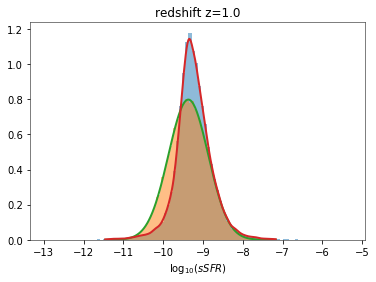

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [ ]:
# number of samples
N = 100000

# target density
z = 1.
tuniv = WMAP9.age(z).value
mu_sSFR = (1e-10)*(1+z)**2.1
target = stats.norm(loc=np.log10(mu_sSFR), scale=0.5)
#target = stats.uniform(loc=-11, scale=3)
log10_sfr_sf = target.rvs(N)

# initial proposal draws
theta = proposal(N)

# compute sSFR for each \theta and weights
sSFR = compute_sSFR(theta, tuniv)
theta = theta[sSFR > 0]
sSFR = sSFR[sSFR > 0]
log10_sSFR_pdf = gaussian_kde(np.log10(sSFR))
weights = target.pdf(np.log10(sSFR))/log10_sSFR_pdf.pdf(np.log10(sSFR))
weights = weights/np.sum(weights)

# importance re-sampling step
theta, sSFR, log10_sSFR_pdf, weights = importance_resample(theta, weights, N, tuniv, target)

# plot the matched distribution
plt.hist(np.log10(sSFR), bins = 100, density=True, alpha=0.5)
plt.hist(log10_sfr_sf, bins = 100, density=True, alpha=0.5)
x = np.linspace(min(log10_sfr_sf), max(log10_sfr_sf), 200)
y = target.pdf(x)
plt.plot(x, y)
plt.plot(x, log10_sSFR_pdf(x))
plt.xlabel(r'$\mathrm{log}_{10}(sSFR)$')
plt.title('redshift z={}'.format(z))
plt.show()

# biject the samples for training the MAF
phi = bijector.forward(theta.astype(np.float64)).numpy().astype(np.float32)

# train the MAF
epochs = 300
pbar = tqdm.tnrange(epochs, desc="Iterations")
for epoch in pbar:
    pbar.set_postfix(loss=train_step_samples(phi, weights).numpy())
    
# re-sample and re-weight
phi = maf.sample(N).numpy().astype(np.float64)
theta = bijector.inverse(phi).numpy()
sSFR = compute_sSFR(theta, tuniv)
theta = theta[sSFR > 0]
phi = phi[sSFR > 0]
sSFR = sSFR[sSFR > 0]
log10_sSFR_pdf = gaussian_kde(np.log10(sSFR))
weights = target.pdf(np.log10(sSFR))/log10_sSFR_pdf.pdf(np.log10(sSFR))
weights = weights/np.sum(weights)

# plot the matched distribution
plt.hist(np.log10(sSFR), bins = 100, density=True, alpha=0.5)
plt.hist(log10_sfr_sf, bins = 100, density=True, alpha=0.5)
x = np.linspace(min(log10_sfr_sf), max(log10_sfr_sf), 200)
y = target.pdf(x)
plt.plot(x, y)
plt.plot(x, log10_sSFR_pdf(x))
plt.xlabel(r'$\mathrm{log}_{10}(sSFR)$')
plt.title('redshift z={}'.format(z))
plt.show()

# re-train the MAF
pbar = tqdm.tnrange(epochs, desc="Iterations")
for epoch in pbar:
    pbar.set_postfix(loss=train_step_samples(phi, weights).numpy())
    
# re-sample and compute weights
phi = maf.sample(N).numpy().astype(np.float64)
theta = bijector.inverse(phi).numpy()
sSFR = compute_sSFR(theta, tuniv)
theta = theta[sSFR > 0]
phi = phi[sSFR > 0]
sSFR = sSFR[sSFR > 0]
log10_sSFR_pdf = gaussian_kde(np.log10(sSFR))
weights = target.pdf(np.log10(sSFR))/log10_sSFR_pdf.pdf(np.log10(sSFR))
weights = weights/np.sum(weights)

# plot the matched distribution
plt.hist(np.log10(sSFR), bins = 100, density=True, alpha=0.5)
plt.hist(log10_sfr_sf, bins = 100, density=True, alpha=0.5)
x = np.linspace(min(log10_sfr_sf), max(log10_sfr_sf), 200)
y = target.pdf(x)
plt.plot(x, y)
plt.plot(x, log10_sSFR_pdf(x))
plt.xlabel(r'$\mathrm{log}_{10}(sSFR)$')
plt.title('redshift z={}'.format(z))
plt.show()

Plot the matched prior as a function of redshift (compare to MIZUKI prior)

In [ ]:
zs = np.linspace(0, 2, 11)
for z in zs:
    
    tuniv = WMAP9.age(z).value
    mu_sSFR = (1e-10)*(1+z)**2.1
    target_ = stats.norm(loc=np.log10(mu_sSFR), scale=0.3)
    
    phi = maf.sample(N).numpy().astype(np.float64)
    theta = bijector.inverse(phi).numpy()
    sSFR = compute_sSFR(theta, tuniv)
    
    theta = theta[sSFR > 0]
    phi = phi[sSFR > 0]
    sSFR = sSFR[sSFR > 0]
    log10_sSFR_pdf = gaussian_kde(np.log10(sSFR))
    
    plt.hist(np.log10(sSFR), bins = 100, density=True, alpha=0.5)
    plt.hist(log10_sfr_sf, bins = 100, density=True, alpha=0.5)
    x = np.linspace(min(log10_sfr_sf), max(log10_sfr_sf), 200)
    y = target.pdf(x)
    plt.plot(x, y)
    plt.plot(x, target_.pdf(x))
    plt.plot(x, log10_sSFR_pdf(x))
    plt.xlabel(r'$\mathrm{log}_{10}(sSFR)$')
    plt.title('redshift z={}'.format(z))
    plt.show()

Generate parameter draws from the prior

In [20]:
n_samples = 100000
n_batch = 64

# interpolator for tuniv
tuniv_ = InterpolatedUnivariateSpline(np.linspace(0, 2.5, 100), WMAP9.age(np.linspace(0, 2.5, 100)).value)

for i in trange(n_batch):
    
    # generate SFH parameters from matched prior...
    
    # star-forming galaxies
    phi = maf.sample(n_samples).numpy().astype(np.float64)
    theta_sfh_sf = bijector.inverse(phi).numpy() # star-forming galaxies
    
    # quiescent galaxies
    theta_sfh_q = proposal(10 * n_samples)
    
    # generate other parameter draws
    z_sf = np.random.uniform(0, 2.5, n_samples)
    z_q = np.random.uniform(0, 2.5, 10 * n_samples)
    log10Z = np.random.uniform(-1.98, 0.19, 2 * n_samples)
    dust2 = np.random.uniform(0, 2, 2 * n_samples)**2
    dust_index = np.random.uniform(-1, 0.4, 2 * n_samples)
    
    # sort out the quiescent SFHs
    sSFR_q = compute_sSFR(theta_sfh_q, tuniv_(z_q))
    quiescent = sSFR_q < 1e-11
    theta_sfh_q = theta_sfh_q[quiescent, :]
    z_q = z_q[quiescent]
    if theta_sfh_q.shape[0] < n_samples:
        print('not enough samples!')
    theta_sfh_q = theta_sfh_q[0:n_samples, :]
    z_q = z_q[0:n_samples]
    
    # stack SFH parts
    z = np.concatenate([z_sf, z_q])
    theta_sfh = np.concatenate([theta_sfh_sf, theta_sfh_q])
    
    # stack the samples and save them to file
    theta = np.column_stack([np.column_stack([z, log10Z, dust2, dust_index]), theta_sfh])
    
    # send them to file
    np.save('training_data/parameters/parameters{}.npy'.format(i), theta)

100%|██████████| 50/50 [00:03<00:00, 12.78it/s]
